Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import urllib.request
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
from google.colab import drive, files

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_file = '/content/drive/MyDrive/Dev/Pipes/pipes-augmented.zip'
download_dir = '/tmp/'

zip_ref = zipfile.ZipFile(data_file, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [ ]:
print(len(os.listdir('/tmp/pipes-augmented/good/')))
print(len(os.listdir('/tmp/pipes-augmented/bad/')))

500
500


In [ ]:
file_path = '/tmp/pipes-aug'
source_path = '/tmp/pipes-augmented'

In [ ]:
try:
    os.mkdir('{}'.format(file_path))
    os.mkdir('{}/train'.format(file_path))
    os.mkdir('{}/test'.format(file_path))
    os.mkdir('{}/train/good'.format(file_path))
    os.mkdir('{}/train/bad'.format(file_path))
    os.mkdir('{}/test/good'.format(file_path))
    os.mkdir('{}/test/bad'.format(file_path))
except OSError:
    pass

In [ ]:
import random
from shutil import copyfile
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


GOOD_SOURCE_DIR = '{}/good/'.format(source_path)
TRAIN_GOOD_DIR = '{}/train/good/'.format(file_path)
TEST_GOOD_DIR = '{}/test/good/'.format(file_path)
BAD_SOURCE_DIR = '{}/bad/'.format(source_path)
TRAIN_BAD_DIR = '{}/train/bad/'.format(file_path)
TEST_BAD_DIR = '{}/test/bad/'.format(file_path)

split_size = .8
split_data(GOOD_SOURCE_DIR, TRAIN_GOOD_DIR, TEST_GOOD_DIR, split_size)
split_data(BAD_SOURCE_DIR, TRAIN_BAD_DIR, TEST_BAD_DIR, split_size)

In [ ]:
print('{} GOOD training images'.format(len(os.listdir(TRAIN_GOOD_DIR))))
print('{} BAD training images'.format(len(os.listdir(TRAIN_BAD_DIR))))
print('{} GOOD testing images'.format(len(os.listdir(TEST_GOOD_DIR))))
print('{} BAD testing images'.format(len(os.listdir(TEST_BAD_DIR))))

479 GOOD training images
482 BAD training images
177 GOOD testing images
177 BAD testing images


In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
TRAINING_DIR = '{}/train/'.format(file_path)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    classes=['bad', 'good'],
                                                    save_to_dir='/tmp/augmented/train',
                                                    target_size=(150, 150))

VALIDATION_DIR = '{}/test/'.format(file_path)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              classes=['bad', 'good'],
                                                              class_mode='binary',
                                                              save_to_dir='/tmp/augmented/test',
                                                              target_size=(150, 150))


Found 961 images belonging to 2 classes.
Found 354 images belonging to 2 classes.


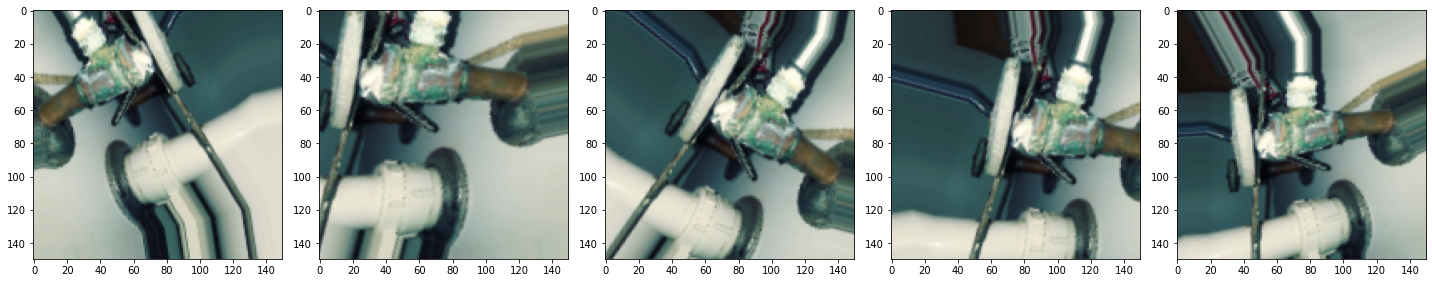

In [ ]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001), #RMSprop(lr=0.000001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=10,
            verbose=1)

Epoch 1/10
25/25 [==============================] - 17s 577ms/step - loss: 0.6715 - acc: 0.6004 - val_loss: 0.4472 - val_acc: 0.8750
Epoch 2/10
25/25 [==============================] - 13s 530ms/step - loss: 0.5022 - acc: 0.8150 - val_loss: 0.3115 - val_acc: 0.9300
Epoch 3/10
25/25 [==============================] - 13s 531ms/step - loss: 0.3653 - acc: 0.8987 - val_loss: 0.2303 - val_acc: 0.9600
Epoch 4/10
25/25 [==============================] - 13s 528ms/step - loss: 0.2860 - acc: 0.9262 - val_loss: 0.1617 - val_acc: 0.9800
Epoch 5/10
25/25 [==============================] - 13s 529ms/step - loss: 0.2243 - acc: 0.9496 - val_loss: 0.1281 - val_acc: 0.9850
Epoch 6/10
25/25 [==============================] - 13s 531ms/step - loss: 0.2008 - acc: 0.9573 - val_loss: 0.1004 - val_acc: 0.9900
Epoch 7/10
25/25 [==============================] - 13s 530ms/step - loss: 0.1619 - acc: 0.9712 - val_loss: 0.0754 - val_acc: 1.0000
Epoch 8/10
25/25 [==============================] - 13s 533ms/step - 

<Figure size 432x288 with 0 Axes>

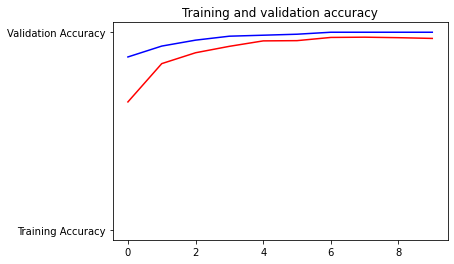

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()



In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0][0]>0.5:
    print("{}: Looks BAD".format(fn))
  else:
    print("{}: Looks GOOD".format(fn))

Saving Good 2.jpg to Good 2.jpg
[[0.]]
[0.]
Good 2.jpg: Looks GOOD


In [ ]:
#!zip -r /tmp/augmented2.zip /tmp/augmented

  adding: tmp/augmented/ (stored 0%)
  adding: tmp/augmented/good/ (stored 0%)
  adding: tmp/augmented/good/_5_5674190.png (deflated 0%)
  adding: tmp/augmented/good/_6_4221409.png (deflated 0%)
  adding: tmp/augmented/good/_15_1632679.png (deflated 0%)
  adding: tmp/augmented/good/_23_4410198.png (stored 0%)
  adding: tmp/augmented/good/_5_3492037.png (deflated 0%)
  adding: tmp/augmented/good/_20_7117782.png (stored 0%)
  adding: tmp/augmented/good/_17_6797607.png (deflated 0%)
  adding: tmp/augmented/good/_17_6334986.png (deflated 0%)
  adding: tmp/augmented/good/_18_1346136.png (deflated 0%)
  adding: tmp/augmented/good/_7_574534.png (deflated 0%)
  adding: tmp/augmented/good/_16_2181569.png (deflated 0%)
  adding: tmp/augmented/good/_15_6283792.png (deflated 0%)
  adding: tmp/augmented/good/_17_1373472.png (deflated 0%)
  adding: tmp/augmented/good/_22_1567627.png (stored 0%)
  adding: tmp/augmented/good/_18_2019041.png (deflated 0%)
  adding: tmp/augmented/good/_17_3277482.png (d

In [ ]:
#files.download("/tmp/augmented2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>